In [3]:
import pandas as pd
import pickle

In [5]:
outfit_data = pd.read_csv("dataset/outfit_data_preprocessed.csv")
product_data = pd.read_csv("dataset/product_data_cleaned.csv")

In [6]:
# outfit_data['cod_modelo_color'] = outfit_data['cod_modelo_color'].str.slice(stop=-3)
outfit_data = outfit_data.drop_duplicates()
product_counts = outfit_data.groupby('cod_modelo_color').size().reset_index(name='counts')

merged_df = pd.merge(outfit_data, outfit_data, how='left', on='cod_outfit')
merged_df = merged_df[merged_df['cod_modelo_color_x'] > merged_df['cod_modelo_color_y']]
merged_df = merged_df.groupby(['cod_modelo_color_x', 'cod_modelo_color_y']).size().reset_index(name='weight')

# normalize the weights by the number of times the product appears in an outfit
merged_df = pd.merge(merged_df, product_counts, how='left', left_on='cod_modelo_color_x', right_on='cod_modelo_color')
# the set is analysed over the condition merged_df['cod_modelo_color_x'] > merged_df['cod_modelo_color_y']
# it means analysing only the superior diagonal matrix associated to the graph  
merged_df['weight'] = merged_df['weight'] / merged_df['counts']

merged_df['edge'] = merged_df.apply(lambda x: (x['cod_modelo_color_y'], x['weight']), axis=1)
merged_df = merged_df.groupby('cod_modelo_color_x').agg({'edge': lambda x: list(x)})
merged_df

,edge
cod_modelo_color_x,
41041002-02,"[(41039067-05, 0.5)]"
41045021-02,"[(41025020-02, 0.14285714285714285)]"
41045815-45,"[(41039067-05, 0.25)]"
41065822-50,"[(41055822-08, 1.0)]"
41083009-08,"[(41069066-05, 0.14285714285714285)]"
...,...
67091003-99,"[(57029209-99, 1.0), (57095923-99, 1.0), (6700..."
67106705-99,"[(57025921-OR, 1.0), (57037880-OR, 1.0), (5708..."
87040069-OR,"[(57000438-OR, 1.0), (57001503-02, 1.0), (5701..."


In [8]:
# pruning_table = pd.merge(product_data, product_data, how='left', on='des_product_aggregated_family')
# pruning_table = pruning_table[pruning_table['cod_modelo_color_x'] > pruning_table['cod_modelo_color_y']]
# pruning_table = pruning_table.groupby('cod_modelo_color_x').agg({'cod_modelo_color_y': lambda x: list(x)})

# pruning_table_dict = pruning_table.to_dict()['cod_modelo_color_y']

In [9]:
import networkx as nx

G = nx.Graph()

for row in merged_df.iterrows():
    nodei = row[0]
    for edge in row[1]['edge']:
        nodej = edge[0]
        # if not nodei in pruning_table_dict or not nodej in pruning_table_dict[nodei]:
        G.add_edge(nodei, nodej, weight=edge[1])


In [10]:
communities = nx.community.louvain_communities(G, weight="weight",resolution=7)

<Axes: >

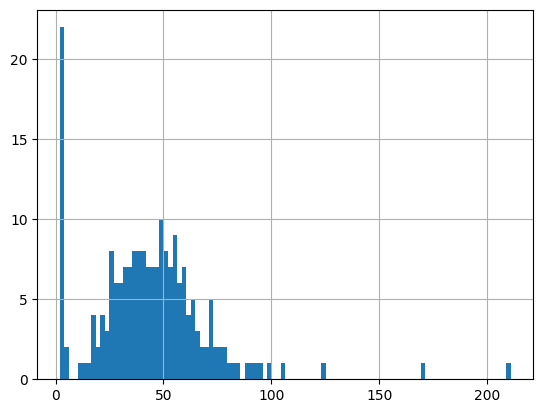

In [11]:
# create a list of tuples with id and community
communities = list(communities)
data = []
for i, community in enumerate(communities):
    data += [(i, item) for item in community]
df = pd.DataFrame(data, columns=['community_id', 'cod_modelo_color'])
df["community_id"].value_counts()
# get histogram of community sizes
df["community_id"].value_counts().hist(bins=100)


In [12]:
df["community_id"].value_counts()

community_id
4      211
83     171
179    124
67     105
144    100
      ... 
79       2
80       2
81       2
95       2
204      2
Name: count, Length: 205, dtype: int64

In [58]:
compatibilities = {}
for i, community in enumerate(communities):
    for item in community:
        compatibilities[item] = i
               
with open('dataset/compatibilities.pickle', 'wb') as handle:
    pickle.dump(compatibilities, handle, protocol=pickle.HIGHEST_PROTOCOL)